https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
import re
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from category_encoders.target_encoder import TargetEncoder
import umap
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import shap
import pickle

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24460\3443027451.py:12: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
dataset = pd.read_csv('data/weatherAUS.csv')

Okay, so we have all of these locations a-and we also have wind speed and direction. We can use nearby locations at the same day or during previous week. The rain could possibly travel from nearby locations.
Also, and this should be our first choice, we should consider data from previous week at the same location we are trying to predict weather for.

But first of all, we need to look at the data. Split the data and then look at it.

I will split the data in a way that preserves all of the locations. The test set will consist of the most recent dates in the dataset.

In [3]:
dataset.sort_values(['Date', 'Location'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [4]:
dataset.iloc[109102:].head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
109102,2015-06-14,Woomera,13.3,16.2,0.0,NaN,NaN,E,33.0,E,...,97.0,88.0,1021.8,1019.0,7.0,7.0,13.6,15.5,No,No
109103,2015-06-15,Adelaide,13.2,15.5,1.2,2.8,NaN,E,24.0,SSE,...,84.0,75.0,1021.5,1018.6,NaN,NaN,13.9,15.4,Yes,Yes
109104,2015-06-15,Albany,13.6,18.8,0.8,1.2,5.9,NaN,NaN,SE,...,78.0,66.0,1023.1,1021.4,6.0,2.0,16.2,17.7,No,Yes
109105,2015-06-15,Albury,1.8,14.0,0.2,NaN,NaN,ESE,17.0,NaN,...,100.0,70.0,1027.4,1023.5,4.0,8.0,5.9,13.9,No,Yes
109106,2015-06-15,AliceSprings,10.2,25.6,0.0,2.4,7.5,WNW,31.0,NE,...,90.0,35.0,1019.8,1016.0,8.0,6.0,15.7,24.2,No,No


In [5]:
(dataset.shape[0] - 109103)/dataset.shape[0]

0.24994500206242265

As indeces are sorted by date and location, it is clear that at the 109103's index the locations are rounding up and starting from the beginning, which means, I can split there to have a test set which size is almost 25% of the whole dataset.

In [6]:
train, test = dataset.iloc[:109103], dataset.iloc[109103:]

Probability of rain in testset: 0.28180
</br>Probability of rain in trainset: 0.2864

RainToday vs RainTomorrow:

In [7]:
def compare(data, filter_, filter_verbose, column, strategy='median'):
    if strategy == 'median':
        true = data.loc[filter_, column].median()
        false = data.loc[~filter_, column].median()
    elif strategy == 'mean':
        true = data.loc[filter_, column].mean()
        false = data.loc[~filter_, column].mean()
    else:
        raise ValueError('Wrong strategy.')
    print(f'{column} when {filter_verbose}:')
    print(f'{strategy} if true: {true}, {strategy} if false: {false}\ndifference: {true-false}')

Comparing against target value in general:

In [8]:
cols = ['WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Rainfall', 'Sunshine']
for col in cols:
    compare(train, train.RainTomorrow == 'Yes', 'RainTomorrow', col)
    print()

WindGustSpeed when RainTomorrow:
median if true: 44.0, median if false: 37.0
difference: 7.0

WindSpeed9am when RainTomorrow:
median if true: 15.0, median if false: 13.0
difference: 2.0

WindSpeed3pm when RainTomorrow:
median if true: 19.0, median if false: 17.0
difference: 2.0

Humidity9am when RainTomorrow:
median if true: 80.0, median if false: 67.0
difference: 13.0

Humidity3pm when RainTomorrow:
median if true: 70.0, median if false: 48.0
difference: 22.0

Pressure9am when RainTomorrow:
median if true: 1014.2, median if false: 1018.3
difference: -4.099999999999909

Pressure3pm when RainTomorrow:
median if true: 1012.1, median if false: 1015.9
difference: -3.7999999999999545

Cloud9am when RainTomorrow:
median if true: 7.0, median if false: 4.0
difference: 3.0

Cloud3pm when RainTomorrow:
median if true: 7.0, median if false: 4.0
difference: 3.0

Temp9am when RainTomorrow:
median if true: 16.1, median if false: 16.8
difference: -0.6999999999999993

Temp3pm when RainTomorrow:
median

Temperature and pressure are lower, wind speed, himidity and clouds are higher.

How many rainy days were there prior to the target date?

In [17]:
roll = rolling_features_for_all_locations(train.RainToday == 'Yes', train.Location, period=3, shift=0, strategy='sum')

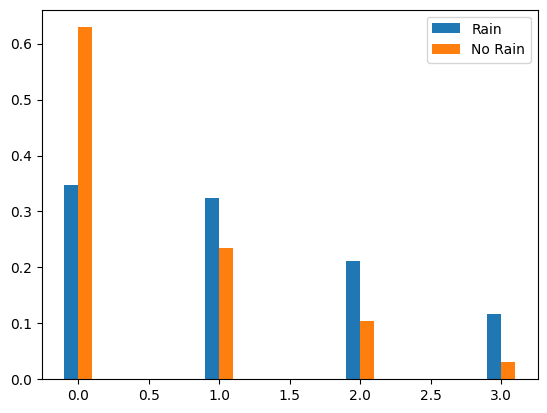

In [19]:
ax = plt.subplot(111)
bar_ = roll.loc[train.RainTomorrow == 'Yes'].value_counts(normalize=True).sort_index()
ax.bar(bar_.index-0.05, bar_.values, width=0.1, label='Rain')
bar_ = roll.loc[train.RainTomorrow == 'No'].value_counts(normalize=True).sort_index()
ax.bar(bar_.index+0.05, bar_.values, width=0.1, label='No Rain')
plt.legend()

Amount of rainy days vs month:

In [50]:
series_ = train_prep.loc[train_prep.RainTomorrow == 1, 'Month'].value_counts().sort_index()

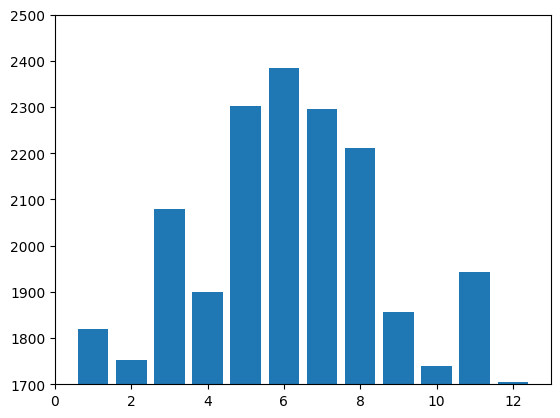

In [51]:
plt.bar(series_.index, series_.values)
ax = plt.axis([0, 13, 1700, 2500])

Probability of rain vs location:

Location names listed below can be found in multiple states of Australia, so I looked up on http://www.bom.gov.au/climate/dwo which towns they meant exactly.
</br>Portland (__Victoria__, New South Wales)
</br>Dartmoor (__Victoria__, Western Australia)
</br>Perth (Tasmania, __Western Australia__)
</br>Richmond (South Australia, __New South Wales__, Victoria)

In [ ]:
map_ = folium.Map(preprocessor.locations.iloc[-1, [-2,-1]], width=500,height=500, tiles='OpenStreetMap', zoom_start=4)

rains_vs_locations = train_prep.loc[train_prep.RainTomorrow ==1, 'Location'].value_counts(normalize=True)
for Location, latitude, longitude in preprocessor.locations[['Location', 'Latitude', 'Longitude']].values[:-1]:
    folium.CircleMarker(location=[latitude, longitude],
                        radius=rains_vs_locations.loc[Location]*400,
                        weight=5).add_to(map_)
map_

Most rains fall on seashores.

Get distance to seashore: https://stackoverflow.com/questions/65300026/distance-from-ships-to-coastline-in-nautical-miles

In [ ]:
def wind_direction_vs_city(data, city, rain = True):
    if rain:
        wind = data.loc[data.Location.str.contains(city) & data.RainTomorrow == 1, ['WindGustDir']]
    else:
        wind = data.loc[data.Location.str.contains(city) & data.RainTomorrow == 0, ['WindGustDir']]
    wind.value_counts().plot.bar()
    r = plt.xticks(rotation = 30)
    plt.show()
    city_map = folium.Map(preprocessor.locations.loc[preprocessor.locations.Location.str.contains(city), ['Latitude', 'Longitude']], width=500,height=500, tiles='OpenStreetMap', zoom_start=10)
    return city_map

In [ ]:
city = wind_direction_vs_city(train, 'Portland')

In [ ]:
city

In [ ]:
city = wind_direction_vs_city(train, 'Richmond')

In [ ]:
city

In [ ]:
city = wind_direction_vs_city(train, 'Witchcliffe')

In [ ]:
city

In [ ]:
city = wind_direction_vs_city(train, 'Cairns')

In [ ]:
city

Most importantly, winds come from all over the place 

In [ ]:
city = wind_direction_vs_city(train, 'Cairns', rain=False)

Rain comes when speed gusts come from plains or coastlines.
</br>Target encoders with respect to location should be good on WindGustDir.

Violin plots:

In [ ]:
def rolls(series_, period, shift, difference=False, strategy = 'median'):
    roll = rolling_features_for_all_locations(series_, train.Location, period=period, shift=shift, strategy=strategy)
    if difference:
        roll = (series_ - roll).rename(f'{series_.name}_{period}_days')
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
    for train_i, test_i in split.split(train_prep, train_prep.Location):
        sample, y = roll.loc[test_i], train.RainTomorrow.fillna('No').loc[test_i]
    sns.violinplot(x=sample, y = y)    

In [ ]:
rolls(train.Humidity3pm, 3, 1, True, 'median')

If RainTomorrow, then Humidity3pm is somewhat higher than average (median) humidity for the past 3 days.

In [ ]:
series_ = train_prep.Humidity3pm/(train_prep.Sunshine+1)
series_ = series_.sample(n=1000)
sns.violinplot(x=series_, y=train.RainTomorrow[series_.index])

Find whether or not there was rain at neighboring locations. Oh, so it’s like RainToday_Albany, RainToday_Richmond and stuff like that. I can target encode those features with respect to locations and then sum them up to a “based on other locations today” feature

In [42]:
class Preprocessor:
    def __init__(self, numerical_impute_strategy, categorical_impute_strategy, roll_cols, roll_strategies, roll_period):
        if len(roll_cols) != len(roll_strategies):
            raise ValueError('Value Error: len(roll_cols) != len(roll_strategies).')
        self.locations = None
        self.numerical_impute_strategy = numerical_impute_strategy
        self.categorical_impute_strategy = categorical_impute_strategy
        self.roll_cols = roll_cols
        self.roll_strategies = roll_strategies
        self.roll_period = roll_period
        
    def preprocess(self, _data, visualize=False):
        data = _data.copy(deep=True)
        
        for column in ['RainToday', 'RainTomorrow']:
            data.loc[data[column] == 'Yes', column] = 1
            data.loc[data[column] == 'No', column] = 0

        data['Year'] = pd.DatetimeIndex(data['Date']).year
        data['Month'] = pd.DatetimeIndex(data['Date']).month
        
        if not visualize:
            self.impute(data)

        data['Location'] = data['Location'].apply(lambda loc: ' '.join(re.findall('[A-Z][^A-Z]+|[A-Z]+', loc)))
        data.loc[data.Location == 'Portland', 'Location'] = 'Portland, Victoria'
        data.loc[data.Location == 'Dartmoor', 'Location'] = 'Dartmoor, Victoria'
        data.loc[data.Location == 'Perth', 'Location'] = 'Perth, Western Australia'
        data.loc[data.Location == 'Richmond', 'Location'] = 'Richmond, New South Wales'
        data['Location'] = data.Location + ', Australia'
        
        if self.locations is None:
            geolocator = Nominatim(user_agent="rain-in-australia-app")
            locations = {'Location': [], 'Address': [], 'Latitude': [], 'Longitude': []}
            for location in data.Location.unique().tolist()+['Australia']:
                location_enc = geolocator.geocode(location, language='en')
                if location_enc is None:
                    raise ValueError(f'Location not found: {location}')
                locations['Location'] += [location]
                locations['Address'] += [location_enc.address]
                locations['Latitude'] += [location_enc.latitude]
                locations['Longitude'] += [location_enc.longitude]    
            self.locations = pd.DataFrame(locations)
        data = data.merge(self.locations[['Location','Latitude','Longitude']], left_on='Location', right_on='Location')
        
        if visualize:
            data['Location'] = data['Location'].apply(lambda loc: loc.split(', ')[0])
        
        data = self.RainToday_Locations(data)
        
        if not visualize:
            data = self.target_encoding(data)
            
        for i, col in enumerate(self.roll_cols):
            data[f'{col}_{self.roll_period}days'] = Preprocessor.rolling_features_for_all_locations(data[col], 
                                                                                       data.Location, 
                                                                                       period=self.roll_period,
                                                                                       shift=1,
                                                                                       strategy=self.roll_strategies[i])
            
        return data
    
    def impute(self, data):
        columns = data.columns[2:-2]
        dtypes = data.dtypes[2:-2]
        numerical = [column for idx, column in enumerate(columns) if dtypes[idx] == float]
        categorical = [column for idx, column in enumerate(columns) if dtypes[idx] == object]
        if self.numerical_impute_strategy == 'mean':
            data[numerical] = data.groupby(['Month', 'Location'])[numerical].transform(lambda x: x.fillna(x.mean()))
        elif self.numerical_impute_strategy == 'median':
            data[numerical] = data.groupby(['Month', 'Location'])[numerical].transform(lambda x: x.fillna(x.median()))
        else:
            raise ValueError('Wrong numerical impute strategy.')
        
        if self.categorical_impute_strategy == 'mode':
            data[categorical] = data.groupby(['Month', 'Location'])[categorical].transform(lambda x: x.fillna(x.mode()))
        else:
            raise ValueError('Wrong categorical impute strategy.')
    
    def RainToday_Locations(self, data):
        grouped = data.groupby('Date')[['Location', 'RainToday']].apply(lambda r: r.set_index('Location').T)
        grouped = grouped.reset_index().drop('level_1', axis=1)
        if ',' in grouped.columns[1]:
            grouped.columns = ['Date']+['RainToday_'+col[:col.index(',')] for col in grouped.columns[1:]]
        else:
            grouped.columns = ['Date']+['RainToday_'+col for col in grouped.columns[1:]]
        return data.merge(grouped, left_on='Date', right_on='Date')
    
    def target_encoding(self, _data):
        data = _data.copy(deep=True)
        data['Month_Location'] = data['Month']
        location_cols = [column for column in data.columns if 'RainToday_' in column] + ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Location']

        for location in data.Location.unique():
            location_encoder = TargetEncoder(cols=location_cols, handle_missing = 0)
            location_df = data.loc[data.Location == location]
            data.loc[data.Location == location] = location_encoder.fit_transform(location_df, location_df.RainTomorrow)
        
        
        location_encoder = TargetEncoder(cols=['Location', 'Month'])
        encoded = location_encoder.fit_transform(data, data.RainTomorrow)
        
        for c in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            encoded[c] = encoded[c].astype(float)
        return encoded
    
    @staticmethod
    def rolling_features_for_all_locations(series_, locations, period, shift, strategy):
        
        def rolling_features_for_location(series_, period, shift, strategy):
            first_n = []
            for i in range(period):
                if i == 0:
                    first_n += [series_[i]]
                else:
                    if strategy == 'mean':
                        first_n += [series_[:i+1-shift].mean()]
                    elif strategy == 'median':
                        first_n += [series_[:i+1-shift].median()]
                    elif strategy == 'sum':
                        first_n += [series_[:i+1-shift].sum()]
                    else:
                        raise ValueError('Wrong strategy.')

            if strategy == 'mean':
                new_series = series_.shift(shift).rolling(period).mean()
            elif strategy == 'median':
                new_series = series_.shift(shift).rolling(period).median()
            elif strategy == 'sum':
                new_series = series_.shift(shift).rolling(period).sum()
            else:
                raise ValueError('Wrong strategy.')

            new_series[:period] = first_n
            return new_series
        
        all_locations = []
        for location in locations.unique():
            one_location, index = series_[locations == location].reset_index(drop=True, inplace=False), series_[locations == location].index.to_series()
            new_series_for_location = rolling_features_for_location(one_location, period, shift, strategy)
            new_series_for_location.index = index
            all_locations += [new_series_for_location]
        return pd.concat(all_locations, axis=0)
    
    

In [52]:
roll_cols = [col for col in train.columns[2:-1] if train.dtypes[col] != object or col == 'RainToday']

In [53]:
roll_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [44]:
roll_strategies = ['mean']*16 + ['sum']

In [45]:
preprocessor = Preprocessor('median', 'mode', 
                            roll_cols=roll_cols, 
                            roll_strategies=roll_strategies,
                            roll_period=7)
train_prep = preprocessor.preprocess(train, visualize=True)

In [46]:
train_prep

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm_7days,Humidity9am_7days,Humidity3pm_7days,Pressure9am_7days,Pressure3pm_7days,Cloud9am_7days,Cloud3pm_7days,Temp9am_7days,Temp3pm_7days,RainToday_7days
0,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,20.000000,68.000000,29.000000,1019.700000,1015.000000,7.000000,7.000000,14.400000,23.600000,0.0
1,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,20.000000,68.000000,29.000000,1019.700000,1015.000000,7.000000,7.000000,14.400000,23.600000,0.0
2,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,18.500000,74.000000,32.500000,1016.050000,1011.700000,6.000000,5.000000,15.950000,24.650000,1.0
3,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,14.333333,76.666667,44.666667,1013.866667,1010.200000,6.666667,5.666667,15.766667,23.166667,2.0
4,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,16.750000,73.000000,47.500000,1011.775000,1009.400000,5.500000,6.000000,15.200000,20.900000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109098,2015-06-14,Witchcliffe,4.2,15.6,0.8,NaN,NaN,ESE,37.0,NaN,...,14.571429,81.285714,69.428571,1024.242857,1022.328571,NaN,NaN,14.200000,17.128571,NaN
109099,2015-06-14,Woomera,13.3,16.2,0.0,NaN,NaN,E,33.0,E,...,16.285714,71.571429,45.857143,1027.771429,1025.442857,NaN,NaN,10.557143,17.342857,0.0
109100,2015-06-14,Katherine,18.9,33.2,0.0,4.0,NaN,ENE,28.0,ENE,...,17.428571,67.714286,41.285714,1015.628571,1011.671429,2.000000,3.571429,23.342857,30.657143,0.0
109101,2015-06-14,Nhil,5.5,16.6,0.0,NaN,NaN,ENE,20.0,E,...,20.000000,98.571429,56.000000,1029.057143,1026.628571,NaN,NaN,7.328571,15.114286,0.0


In [24]:
def scatterplot(data, column, n):
    sample = data[column].sample(n=n).sort_index()
    idx = sample.index
    sns.scatterplot(x=idx, y=sample, hue=train_prep.RainTomorrow[idx], palette=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True))

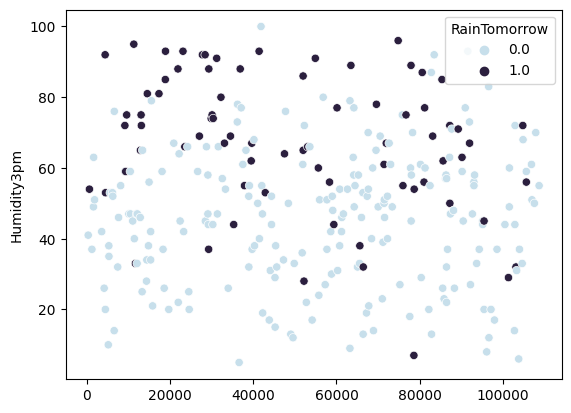

In [25]:
scatterplot(train_prep, 'Humidity3pm', n=300)

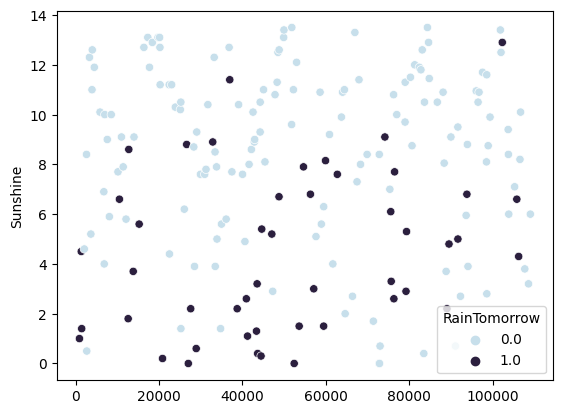

In [26]:
scatterplot(train_prep, 'Sunshine', n=300)

In [27]:
train_prep['Accumulated_probabilities'] = train_prep.iloc[:, 27:-2].sum(axis=1)

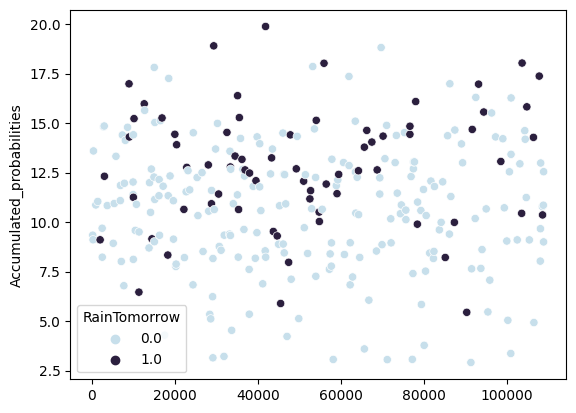

In [28]:
scatterplot(train_prep, 'Accumulated_probabilities', n=300)

### Training and checking the usablity of the features:

In [29]:
train_prep.drop('Date', axis=1, inplace=True)

In [30]:
train_X, train_y = train_prep.drop('RainTomorrow', axis=1), train_prep.RainTomorrow
fixed_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
lgb_params = {

    "objective": "binary",
    "learning_rate": 0.05,
    "num_threads": 10,
    "metric": "AUC",
    "seed": 42,
   "verbose":-1,
    'class_weight': 'balanced',
    
     #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.8,

    "subsample_freq": 1,
    "min_data_in_leaf": 100,

    "num_leaves":20,
    
    "n_estimators":10_000
    
    #categorical features
#     'cat_smooth': 5,
#     'min_data_per_group': 2
#     did not improve the results
    
}
lgb_train = lgb.Dataset(train_X, label=train_y.fillna(0), free_raw_data=False)
result = lgb.cv(lgb_params, lgb_train, 10_000, folds=fixed_skf, callbacks=[lgb.early_stopping(15), lgb.log_evaluation(15)], eval_train_metric=True, return_cvbooster=True)
lgb_params['n_estimators'] = result["cvbooster"].best_iteration

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Unknown parameter: class_weight
Training until validation scores don't improve for 15 rounds
[15]	cv_agg's train auc: 0.87282 + 0.00042575	cv_agg's valid auc: 0.86909 + 0.003211
[30]	cv_agg's train auc: 0.879688 + 0.000559275	cv_agg's valid auc: 0.874926 + 0.00266558
[45]	cv_agg's train auc: 0.885308 + 0.000499221	cv_agg's valid auc: 0.879937 + 0.00249105
[60]	cv_agg's train auc: 0.889877 + 0.000503627	cv_agg's valid auc: 0.883752 + 0.00244057
[75]	cv_agg's train auc: 0.893503 + 0.000496215	cv_agg's valid auc: 0.886655 + 0.00234196
[90]	cv_agg's train auc: 0.896663 + 0.000412435	cv_agg's valid auc: 0.889143 + 0.00233903
[105]	cv_agg's train auc: 0.899271 + 0.000391179	cv_agg's valid auc: 0.891016 + 0.00229223
[120]	cv_agg's train auc: 0.901498 + 0.000437666	cv_agg's valid auc: 0.892556 + 0.00216864
[135]	cv_agg's train auc: 0.903462 + 0.000451272	cv_agg's valid auc: 0.893858 + 0.00211481
[150]	cv_agg's train auc: 0.905274 + 0.000461142	cv_agg's valid auc: 0.894931 

[1365]	cv_agg's train auc: 0.961513 + 0.000397285	cv_agg's valid auc: 0.908718 + 0.00202632
[1380]	cv_agg's train auc: 0.961894 + 0.000392294	cv_agg's valid auc: 0.908757 + 0.00200431
[1395]	cv_agg's train auc: 0.962283 + 0.000396406	cv_agg's valid auc: 0.908803 + 0.00199081
[1410]	cv_agg's train auc: 0.962647 + 0.000377849	cv_agg's valid auc: 0.908853 + 0.00198493
[1425]	cv_agg's train auc: 0.963002 + 0.000396199	cv_agg's valid auc: 0.908873 + 0.00202167
[1440]	cv_agg's train auc: 0.963362 + 0.000401695	cv_agg's valid auc: 0.90892 + 0.00202712
[1455]	cv_agg's train auc: 0.963756 + 0.000379496	cv_agg's valid auc: 0.908938 + 0.00203352
[1470]	cv_agg's train auc: 0.964143 + 0.000389772	cv_agg's valid auc: 0.908958 + 0.0020322
[1485]	cv_agg's train auc: 0.964498 + 0.000353286	cv_agg's valid auc: 0.908968 + 0.00205453
[1500]	cv_agg's train auc: 0.964879 + 0.00035229	cv_agg's valid auc: 0.909007 + 0.00204442
[1515]	cv_agg's train auc: 0.965242 + 0.000361792	cv_agg's valid auc: 0.90903 + 0.0

### Model interpretation:

In [32]:
lgb_clf = lgb.LGBMClassifier(**lgb_params)
lgb_clf.fit(train_X, train_y.fillna(0))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6,
               learning_rate=0.05, metric='AUC', min_data_in_leaf=100,
               n_estimators=1543, num_leaves=20, num_threads=10,
               objective='binary', seed=42, subsample=0.8, subsample_freq=1,
               verbose=-1)

In [33]:
explainer = shap.TreeExplainer(lgb_clf, train_X, model_output="probability")

In [34]:
shap.initjs()
shap_values = explainer.shap_values(train_X)

100%|===================| 109085/109103 [57:29<00:00]        

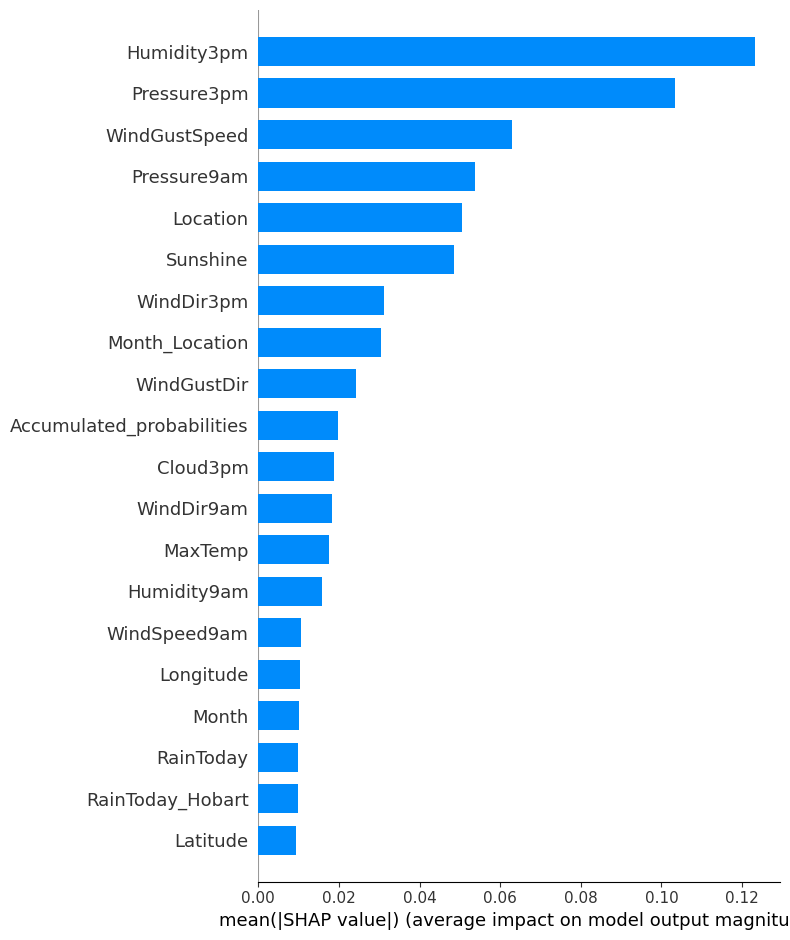

In [37]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [39]:
with open('shap_values.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)